In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils.nbsvm import NBSVM
from sklearn.model_selection import cross_val_score

In [33]:
path = 'hudoc/Article6'

In [34]:
data = []

folders = !ls {path}
for idx, folder in enumerate(folders):
    files = !ls {path}/{folder}
    for file in files:
        data.append({'id': file[:-4], 'text': open(f'{path}/{folder}/{file}').read(), 'label': idx})

In [35]:
df = pd.DataFrame(data=data)

In [36]:
df = shuffle(df)

In [37]:
f = df['text'] != ''
df = df[f]

In [38]:
df['text'][0]

'FIFTH SECTION      CASE OF ZINCHENKO v. UKRAINE (Application no. 63763/11)       JUDGMENT    STRASBOURG 13 March 2014  FINAL 13/06/2014 This judgment has become final under Article 44 § 2 of the Convention. It may be subject to editorial revision. In the case of Zinchenko v. Ukraine,The European Court of Human Rights (Fifth Section), sitting as a Chamber composed of:Mark Villiger, President,Angelika Nußberger,Boštjan M. Zupančič,Ganna Yudkivska,Vincent A. De Gaetano,André Potocki,Aleš Pejchal, judges,and Claudia Westerdiek, Section Registrar,Having deliberated in private on 18 February 2014,Delivers the following judgment, which was adopted on that date:PROCEDURE1.\nThe case originated in an application (no. 2585/06, and subsequently no. 63763/11) against Ukraine lodged with the Court under Article 34 of the Convention for the Protection of Human Rights and Fundamental Freedoms (“the Convention”) by a Ukrainian national, Mr Bogdan Leonidovich Zinchenko (“the applicant”), on 30 Decembe

In [39]:
lens = df.text.str.len()
lens.mean(), lens.std(), lens.max()

(62912.49842271293, 59626.027338846034, 439139)

In [40]:
df.to_csv('Article3.csv')

In [41]:
#df.read_csv('Article3.csv')

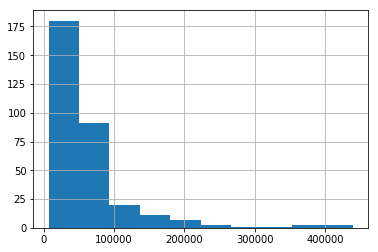

In [42]:
lens.hist()

In [43]:
df.head()

,id,label,text
163,001-174953,0,FIFTH SECTION CASE OF SADKOV v. UKRAINE (A...
144,001-171473,0,FIFTH SECTION CASE OF ARTUR PARKHOMENKO v....
30,001-150298,0,FIRST SECTION CASE OF DRAGOJEVIĆ v. CRO...
156,001-173463,0,THIRD SECTION CASE OF MURTAZALIYEVA v....
257,001-166488,1,SECOND SECTION CASE OF CINDRIĆ AND BEŠLI...


In [44]:
label_cols = ['label']
df['none'] = 1-df[label_cols].max(axis=1)
df.describe()

,label,none
count,317.000000,317.000000
mean,0.529968,0.470032
std,0.499890,0.499890
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [45]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [46]:
train, test = train_test_split(df, test_size=0.2)

In [47]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,4), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=100000 )
trn_term_doc = vec.fit_transform(train['text'])
test_term_doc = vec.transform(test['text'])

In [48]:
trn_term_doc, test_term_doc

(<253x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2457755 stored elements in Compressed Sparse Row format>,
 <64x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 570253 stored elements in Compressed Sparse Row format>)

In [49]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [50]:
x = trn_term_doc
test_x = test_term_doc

In [51]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=50, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [52]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit label


In [53]:
preds_y = (preds>0.5) * 1

In [54]:
test_y = test['label'].as_matrix()

/home/nti14147326/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [55]:
preds_y.shape

(64, 1)

In [56]:
test_y = test_y.reshape(-1, 1)

In [57]:
sum((preds_y == test_y) * 1)/len(test_y)

array([0.71875])

In [58]:
clf = NBSVM(C=1000, alpha=0.00001, beta=0.25)

In [59]:
y_train = train['label'].as_matrix()

/home/nti14147326/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [60]:
X_train = trn_term_doc

In [62]:
X_train.reshape(253, -1)

<253x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 2457755 stored elements in Compressed Sparse Row format>

In [63]:
score = np.mean(cross_val_score(clf, X_train, y_train, cv=10))

In [64]:
score

0.759076923076923